## Assignment 1 
### \<Hengyi Ma> \<a1875198>

In [109]:
#Firstly,import some libraries that are necessary 
import numpy as np
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import tree
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import json
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords

### 1. Reading datasets

In [110]:
#Load the data,then lowercase and tokenize the data,then lowercase the words,because in stopword list all of the words are lowe-case,which will be applied later.
#And combine the title and text sections together as the task requests.Then split the dataset into 3 parts,for section1,we'll use development dataset.
train_size=10000
dev_size=10000
#load the data
stop_words = set(stopwords.words('english'))
data = []
with open('random_30000_hotel_reviews.JSON', 'r') as f:
    for line in f:
        json_data = json.loads(line)
        data.append(json_data)

def clean_and_tokenize(data):
    cleaned_data = []
    for sample in data:
        combined_text = sample['title'] + " " + sample['text']
        cleaned_text = ''.join(char.lower() for char in combined_text if char.isalnum() or char in string.whitespace)
        tokens = word_tokenize(cleaned_text)
        score=sample['ratings']['overall']
        cleaned_data.append({'newtext': tokens, 'overallscore': score})
    return cleaned_data

# Split dataset
def split_data(data, train_size, dev_size):
    train_data = data[:train_size]
    dev_data = data[train_size:train_size + dev_size]
    test_data = data[train_size + dev_size:]
    return train_data, dev_data, test_data

# Apply cleaning and tokenization
cleaned_data = clean_and_tokenize(data)
train_data, dev_data, test_data = split_data(cleaned_data, train_size, dev_size)

### 2. Exploratory Data Analysis (EDA)

In [111]:
#Then save the development dataset into a dataframe for further actions,we can take a look at the data through head()and describe()functions
import pandas as pd
df = pd.DataFrame(dev_data)  
df.head()

,newtext,overallscore
0,"[nice, hotel, great, location, this, was, a, n...",4.0
1,"[perfect, location, and, the, room, was, gener...",4.0
2,"[rude, staff, extra, charges, overall, unimpre...",2.0
3,"[great, location, would, stay, here, again, st...",4.0
4,"[disappointed, in, chicago, i, stayed, at, the...",3.0


In [10]:
df.describe()

,overallscore
count,10000.00000
mean,3.93170
std,1.18936
min,1.00000
25%,3.00000
50%,4.00000
75%,5.00000
max,5.00000


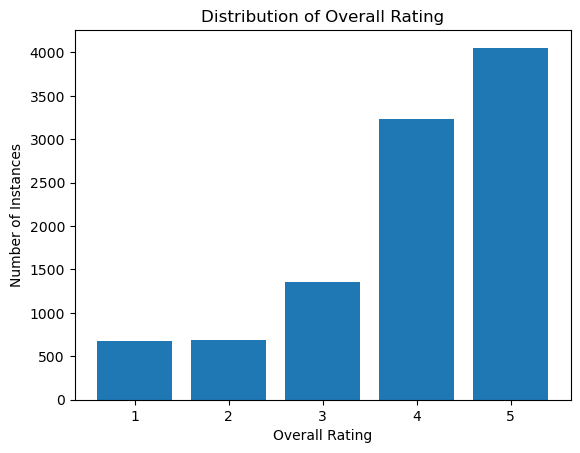

In [112]:
#Distribution of "overall" rating over number of instances,we can find that as the rating increases,the number of samples increases,too.Which means higher ratings
#always have larger amount of samples.
from collections import Counter
import matplotlib.pyplot as plt

ratings = [sample['overallscore'] for sample in dev_data]

rating_counts = {}
for rating in ratings:
    if rating in rating_counts:
        rating_counts[rating] += 1
    else:
        rating_counts[rating] = 1

plt.bar(rating_counts.keys(), rating_counts.values())
plt.xlabel('Overall Rating')
plt.ylabel('Number of Instances')
plt.title('Distribution of Overall Rating')
plt.show()

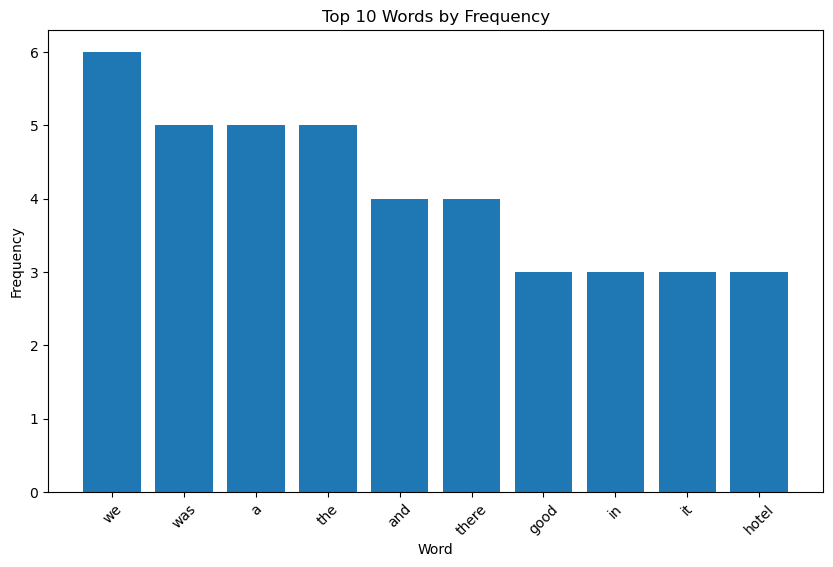

In [113]:
#Then we want to see the top 10 words by frequency occuried in our text section.As we can see,there're a lot of personal Pronouns like 'we' and conjunctions like 'and',which is 
#of little use to our data analysis,so we'll try to delete these stop words from the dataset and take a look at the frequency distribution again then.
for text in df['newtext']:
    all_text = ' '.join(text)
words = all_text.split()
word_counts = Counter(words)
top_words = word_counts.most_common(10)
top_words_df = pd.DataFrame(top_words, columns=['word', 'count'])
plt.figure(figsize=(10, 6))
plt.bar(top_words_df['word'], top_words_df['count'])
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Top 10 Words by Frequency')
plt.xticks(rotation=45)
plt.show()

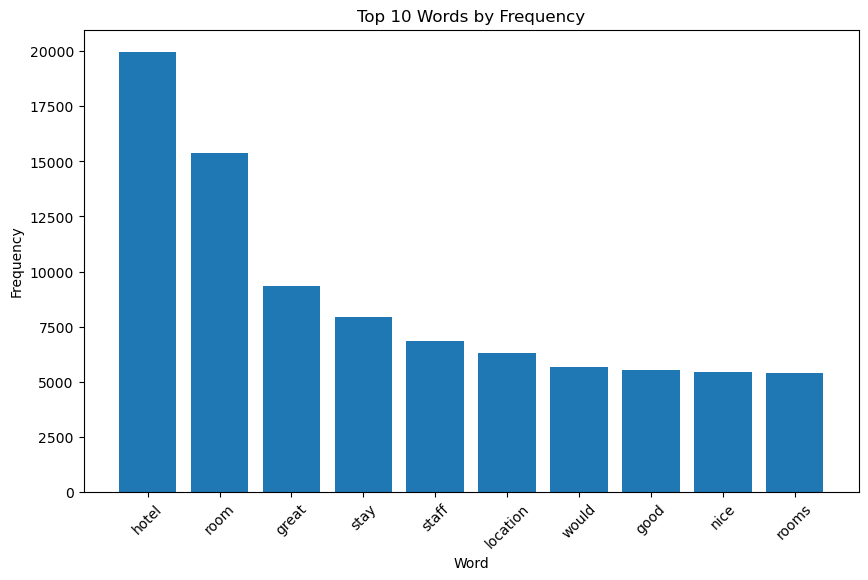

In [114]:
#By deleting stop words,we analysis the top 10 words in the text section again.We can find some useful information which describes the living condition like"great","location",
#"staff","rooms",this reminds us of the main focus of the reviews.
df['newtext'] = df['newtext'].apply(lambda x: [word for word in x if word not in stop_words])
all_words = [word for text in df['newtext'] for word in text]
word_counts = Counter(all_words)
top_words = word_counts.most_common(10)
top_words_df = pd.DataFrame(top_words, columns=['word', 'count'])
plt.figure(figsize=(10, 6))
plt.bar(top_words_df['word'], top_words_df['count'])
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Top 10 Words by Frequency')
plt.xticks(rotation=45)
plt.show()

/opt/conda/Anaconda3/envs/nlp/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


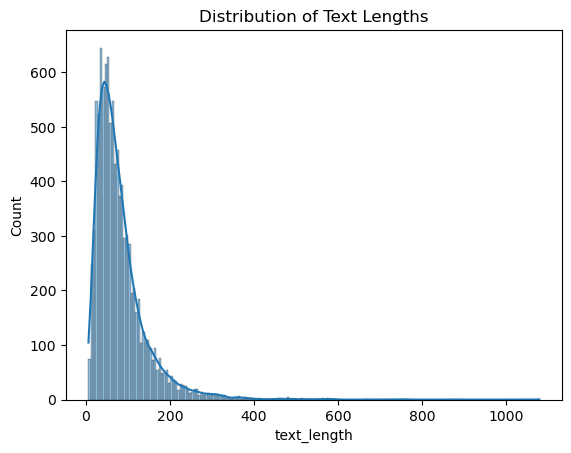

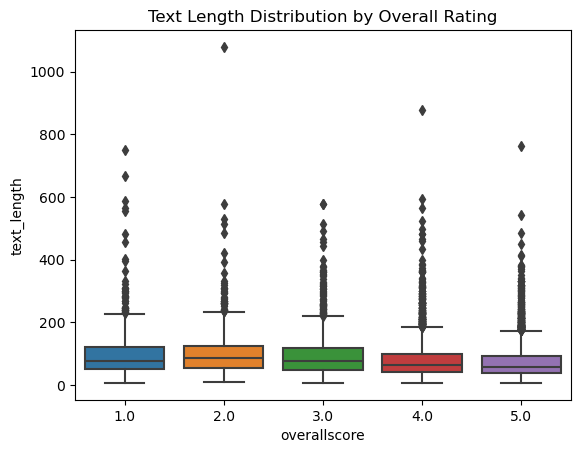

In [115]:
#Use more EDA techniques to gain deeper understanding of data sets,Here we draw the following relationships: distribution chart of text length, 
#relationship chart between text length and overall rating.As we can see,the length of the review mainly focused on 0-200.From the relationship chart between text length 
#and overall rating,We can find that there is no direct and obvious relationship between review text length and ratings
import seaborn as sns
df['text_length'] = df['newtext'].apply(lambda x: len(x))
sns.histplot(df['text_length'], kde=True)
plt.title('Distribution of Text Lengths')
plt.show()
sns.boxplot(x='overallscore', y='text_length', data=df)
plt.title('Text Length Distribution by Overall Rating')
plt.show()

Total number of words: 813474
Number of unique words: 32611


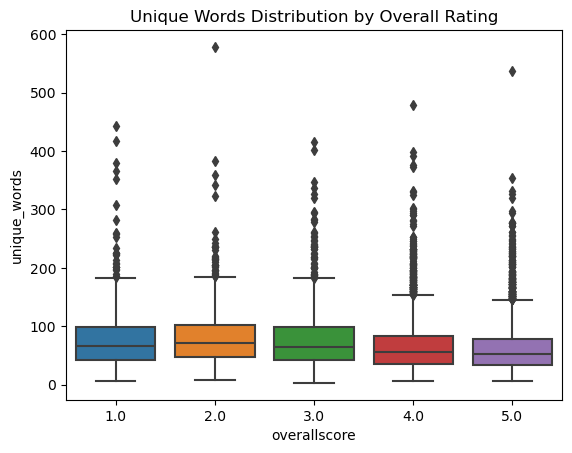

In [116]:
#At the same time, we use the length of unique words to plot the distribution of comments with different ratings. It can be found that, 
#on the whole, there is a trend that the higher the score, the fewer unique words (except in the case of 2 points).
#This may be because the praise words for the hotel are more repetitive when the score is high, and the description of the specific 
#situation is more detailed when the score is low.
words = [word for text in df['newtext'] for word in text]
print(f"Total number of words: {len(words)}")
print(f"Number of unique words: {len(set(words))}")

df['unique_words'] = df['newtext'].apply(lambda x: len(set(x)))
sns.boxplot(x='overallscore', y='unique_words', data=df)
plt.title('Unique Words Distribution by Overall Rating')
plt.show()

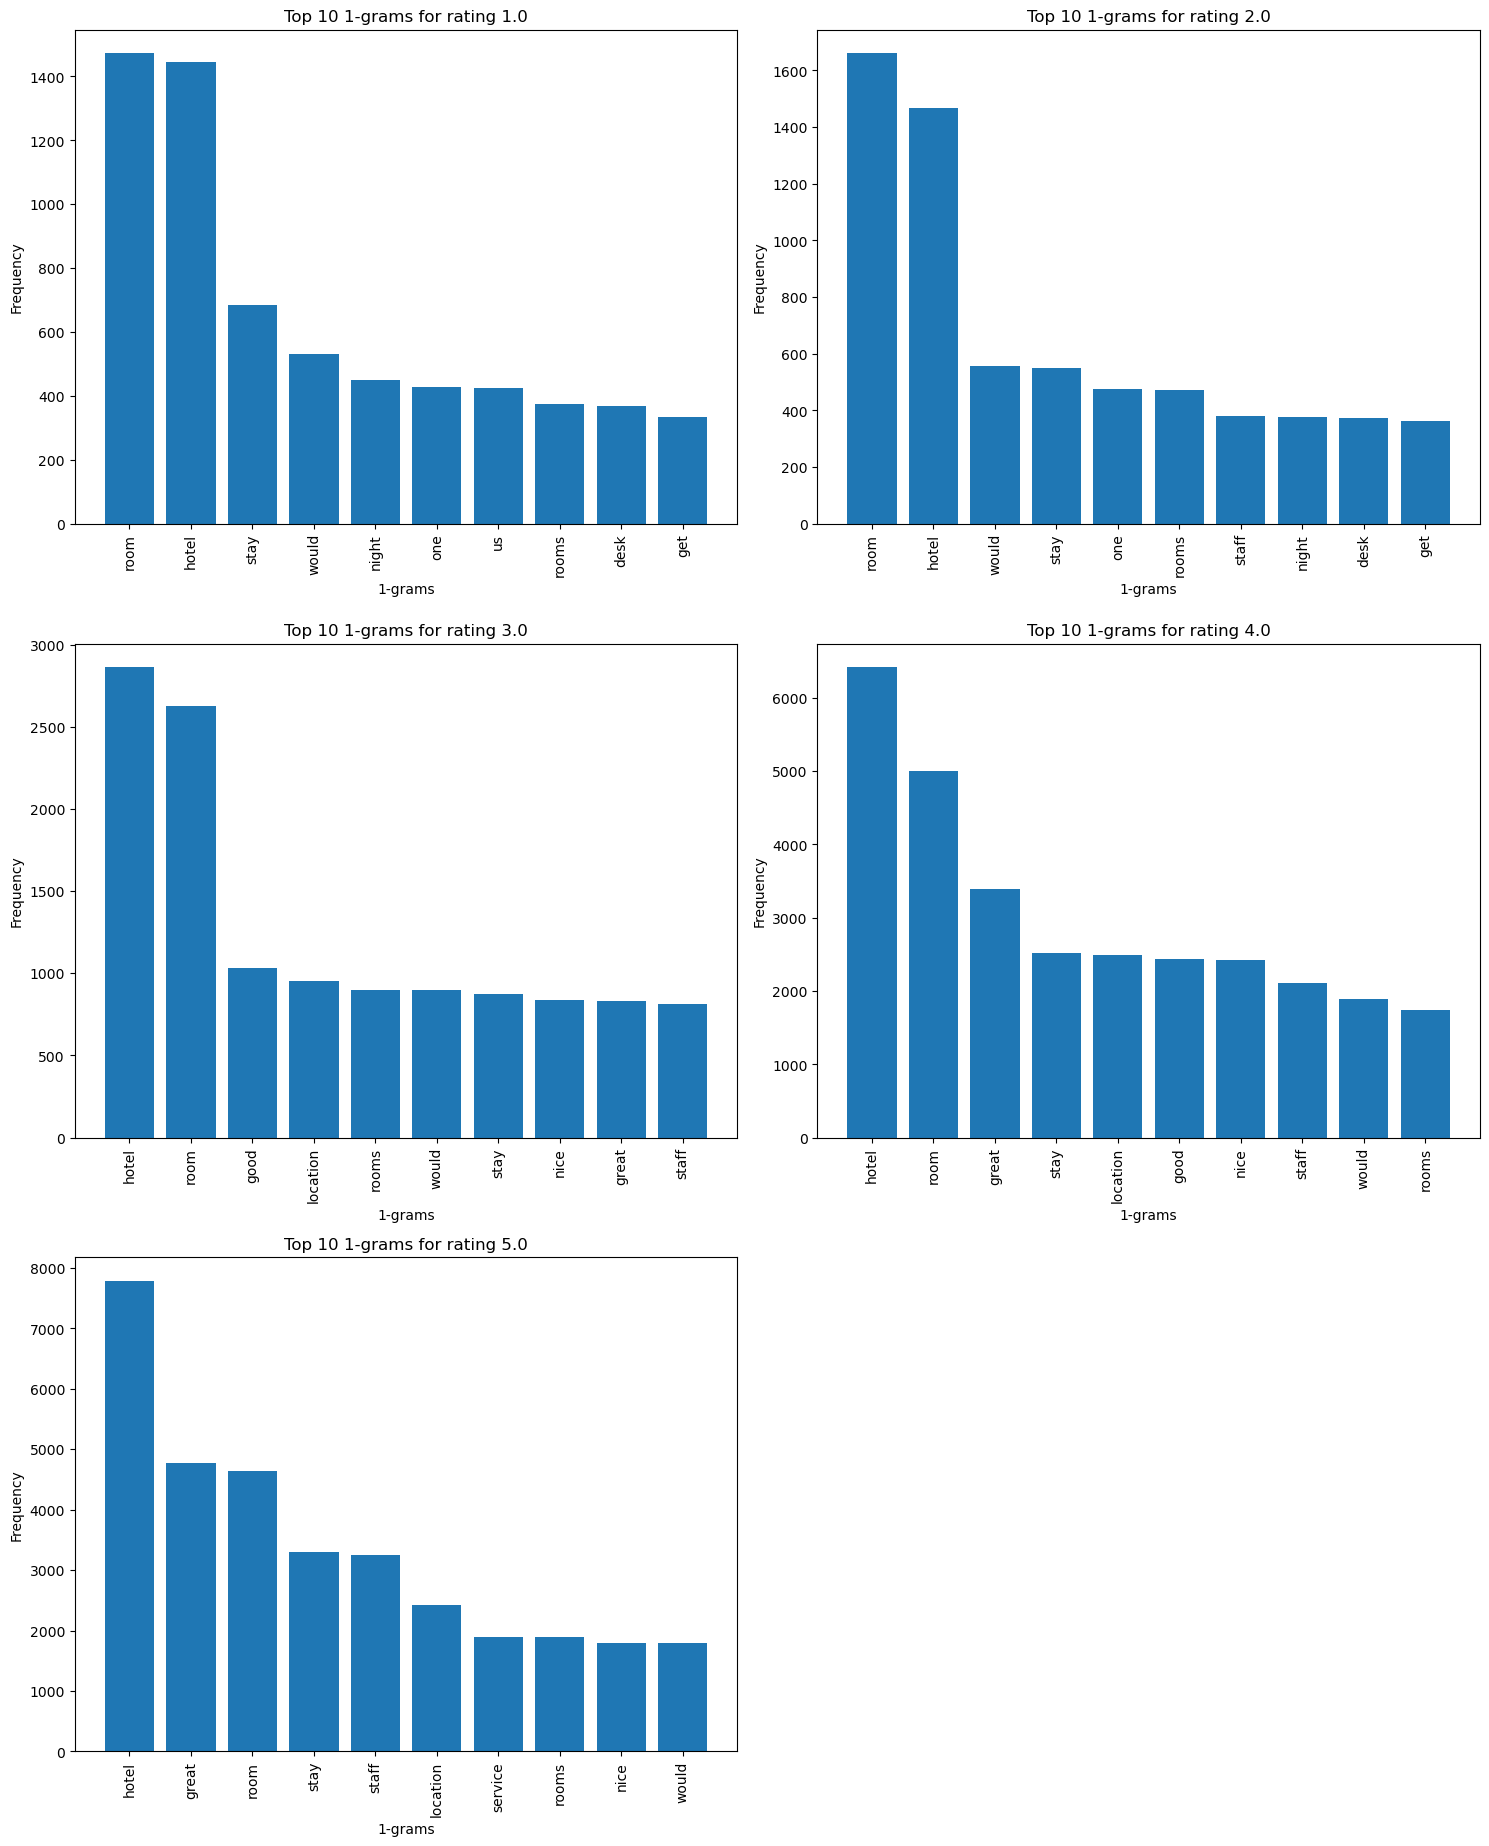

In [117]:
#We hope to use n-gram to try to find whether there are significant differences in the main words in comments under different ratings and print out top 10 words by frequency of 
#different ratings.While we just use 1-gram to see the difference,we can find that there're not significant difference among different ratings,except the words "nice" and "great"
#which don't appear in the top-10 charts,these 2 words only appear in the reviews whose ratings>=3.0。
from nltk import ngrams
from collections import Counter
import matplotlib.pyplot as plt

def generate_ngrams(text, n):
    n_grams = ngrams(text, n)
    return [' '.join(gram) for gram in n_grams]

n_value = 1
plt.figure(figsize=(15,30))

for rate in df['overallscore'].unique():
    words = [word for text in df[df['overallscore'] == rate]['newtext'] for word in text]
    ngrams_list = generate_ngrams(words, n_value)
    ngrams_count = Counter(ngrams_list)
    most_common_ngrams = dict(ngrams_count.most_common(10))

    labels, values = zip(*most_common_ngrams.items())
    indexes = range(len(labels))
    plt.subplot(5, 2, int(rate))  
    plt.bar(indexes, values)
    plt.xlabel(f'{n_value}-grams')
    plt.ylabel('Frequency')
    plt.xticks(indexes, labels, rotation='vertical')
    plt.title(f'Top 10 {n_value}-grams for rating {rate}')

plt.tight_layout()
plt.show()



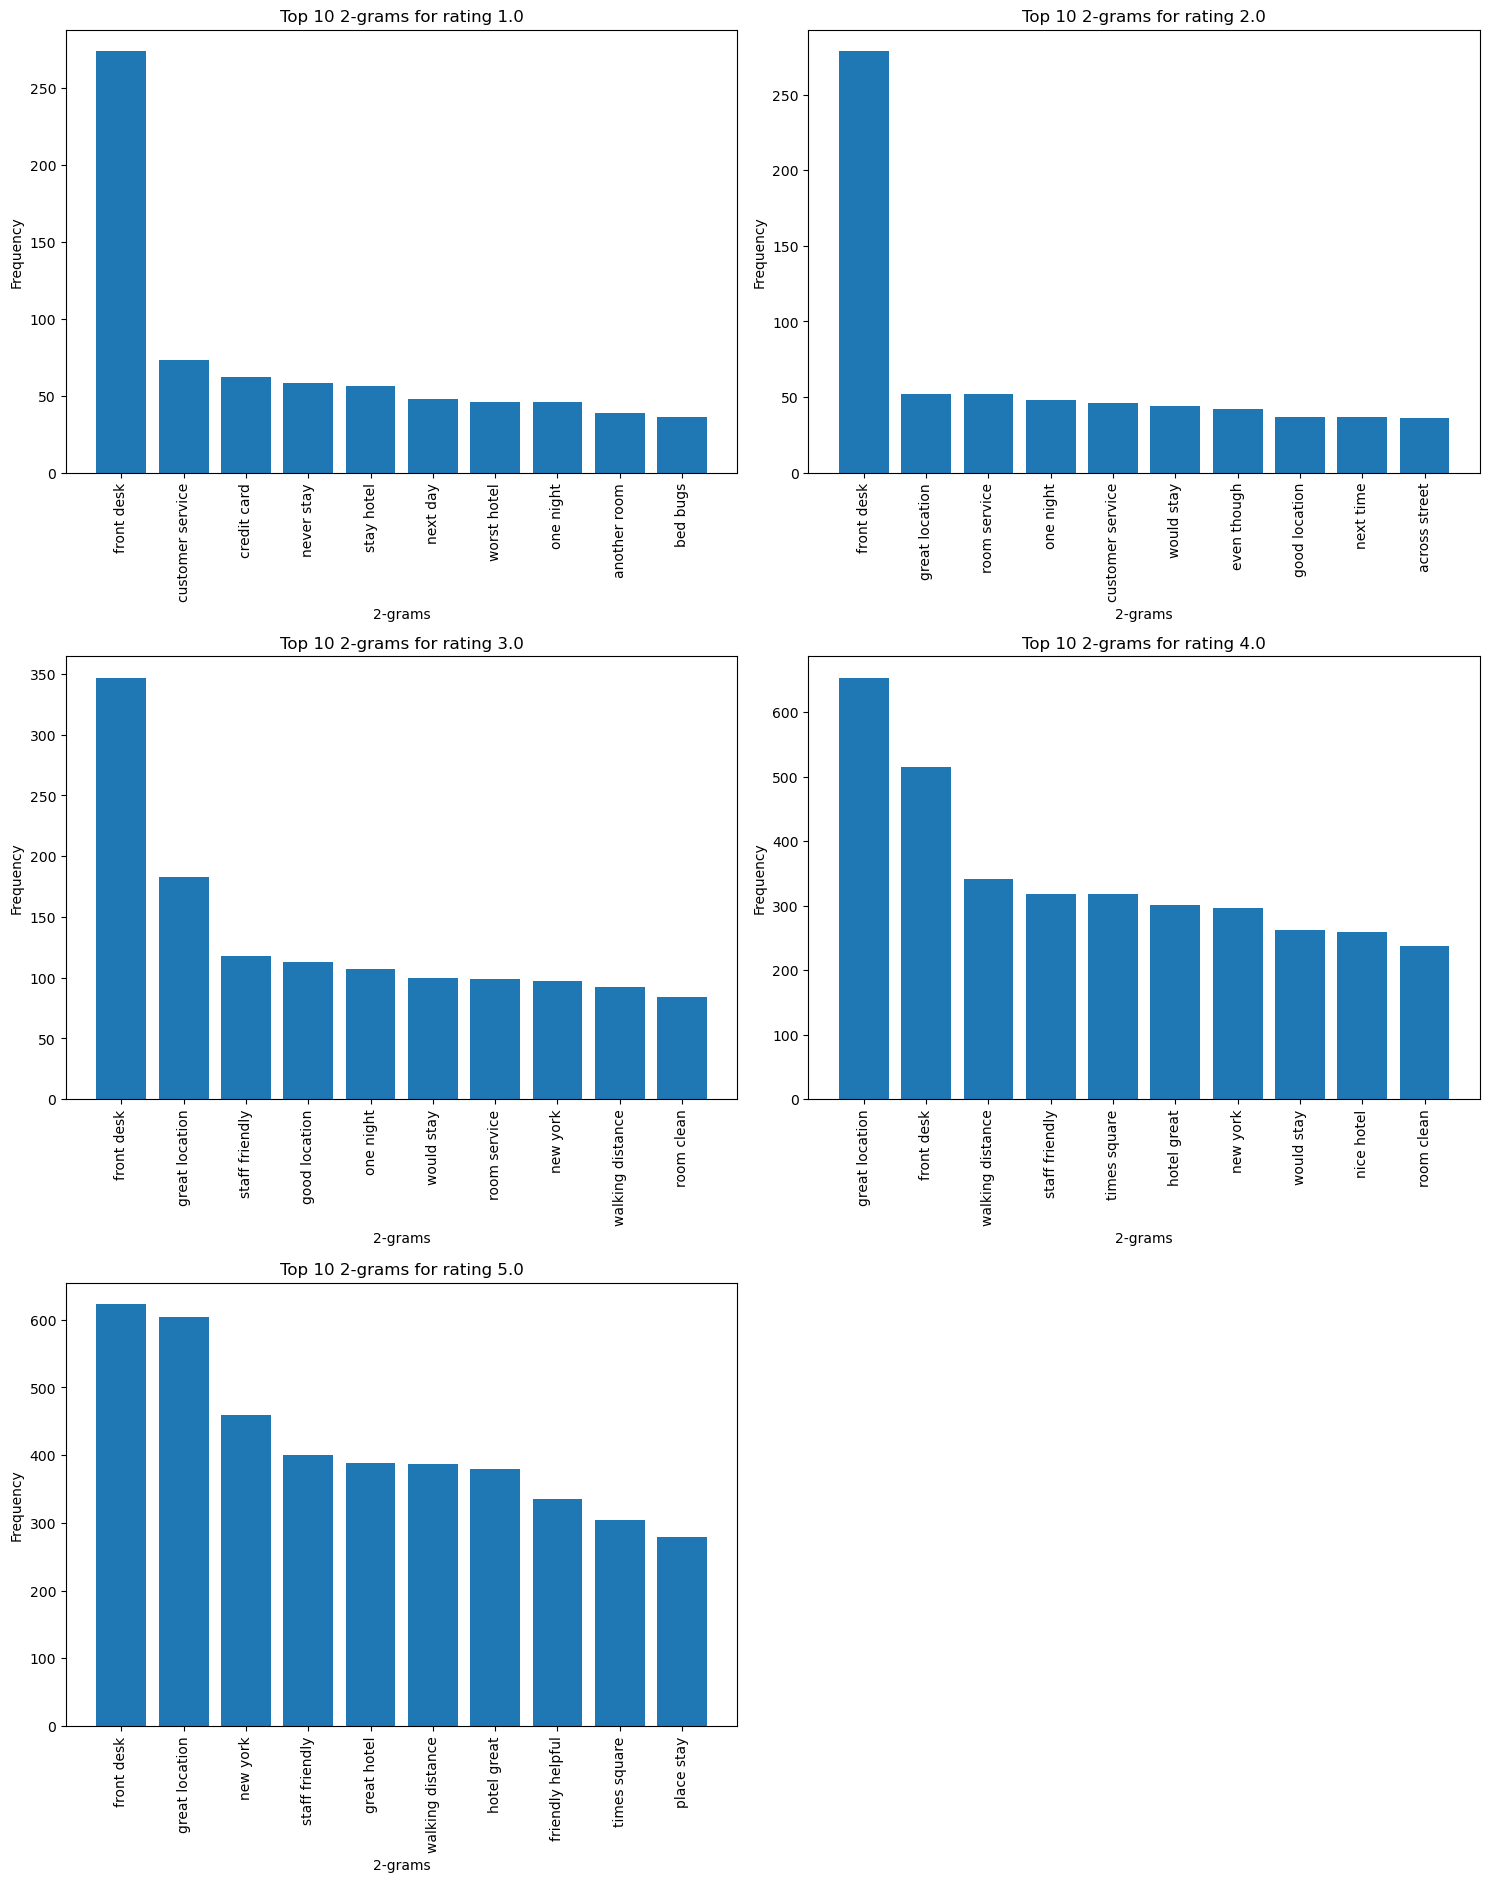

In [17]:
#This time we use 2-grams to re-examine the vocabulary distribution under different ratings.This time we can find more obvious differences. 
#We can find that a large number of positive descriptions like 'great location','room clean' appear in the review content with a score of 3 or greater, but such descriptions 
#do not appear when the score is lower.Therefore, we can consider using 2-grams as a means to distinguish comments in the future.
n_value = 2
plt.figure(figsize=(15,30))

for rate in df['overallscore'].unique():
    words = [word for text in df[df['overallscore'] == rate]['newtext'] for word in text]
    ngrams_list = generate_ngrams(words, n_value)
    ngrams_count = Counter(ngrams_list)
    most_common_ngrams = dict(ngrams_count.most_common(10))

    labels, values = zip(*most_common_ngrams.items())
    indexes = range(len(labels))
    plt.subplot(5, 2, int(rate))  
    plt.bar(indexes, values)
    plt.xlabel(f'{n_value}-grams')
    plt.ylabel('Frequency')
    plt.xticks(indexes, labels, rotation='vertical')
    plt.title(f'Top 10 {n_value}-grams for rating {rate}')

plt.tight_layout()
plt.show()


In [18]:
df

,newtext,overallscore,text_length,unique_words
0,"[nice, hotel, great, location, nice, hotel, pr...",4.0,37,31
1,"[perfect, location, room, generous, size, stay...",4.0,33,31
2,"[rude, staff, extra, charges, overall, unimpre...",2.0,144,117
3,"[great, location, would, stay, stayed, 3, nigh...",4.0,39,36
4,"[disappointed, chicago, stayed, allerton, hote...",3.0,68,59
...,...,...,...,...
9995,"[excellent, hotel, one, best, hotels, stayed, ...",5.0,30,29
9996,"[4th, stay, love, location, convenient, downto...",4.0,14,14
9997,"[amazing, booked, day, left, 85, prepaid, inte...",5.0,42,39
9998,"[hotwire, find, nice, accommodation, landed, 1...",4.0,30,29


### 3. Preprocessing

In [118]:
#For better anylasis,we've already finished some process like deleting stop words and lowercasing the words
#This time,we'll try some further data pre-processing techniques 
#Firstly,according to the distribution of the different label,we can see that the data is imbalanced, while the number of samples with 
#label 1 is only nearly 700,the same thing goes to rating 5 is nearly 4000.So we need to consider to balance the dataset here. 
#We can consider upsampling to simply increase the number of samples from the classes with lower amount of samples by copying.
from sklearn.utils import resample
max_samples = df['overallscore'].value_counts().max()
class_counts = df['overallscore'].value_counts()
class_diffs = max_samples - class_counts
print(class_diffs)
from sklearn.utils import resample
upsampled_dfs = []
for class_label, diff in class_diffs.items():
    if diff==0:
        continue
    else:
        class_df = df[df['overallscore'] == class_label]
        upsampled_class = resample(class_df, replace=True, n_samples=diff)
        upsampled_dfs.append(upsampled_class)
upsampled_df = pd.concat([df] + upsampled_dfs)
print(upsampled_df['overallscore'].value_counts())

overallscore
5.0       0
4.0     817
3.0    2701
2.0    3370
1.0    3382
Name: count, dtype: int64
overallscore
4.0    4054
2.0    4054
3.0    4054
5.0    4054
1.0    4054
Name: count, dtype: int64


In [119]:
#Apart from lowercasing and deleting stop words,Stemming and Lematization are other important methods to simplify the input,we'll try 
#different strategies to generate different kinds of sentences here.
import spacy
lem_df=upsampled_df.copy()
nlp = spacy.load('en_core_web_sm')

In [10]:
#The following steps to generate different kinds of text cost some time,we'll test the performance of using ordinary texts,
#lemmatize texts and stemmed texts to find the best one.

def lemmatize_text(text):
    doc = nlp(str(text))
    lemmatized_tokens = [token.lemma_ for token in doc]
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text

lem_df['newtext'] = lem_df['newtext'].apply(lemmatize_text)
lem_df

,newtext,overallscore
0,"[ ' nice ' , ' hotel ' , ' great ' , ' locatio...",4.0
1,"[ ' perfect ' , ' location ' , ' and ' , ' the...",4.0
2,"[ ' rude ' , ' staff ' , ' extra ' , ' charge ...",2.0
3,"[ ' great ' , ' location ' , ' would ' , ' sta...",4.0
4,"[ ' disappoint ' , ' in ' , ' chicago ' , ' I ...",3.0
...,...,...
4074,"[ ' bed ' , ' bug ' , ' stay ' , ' away ' , ' ...",1.0
3988,"[ ' terrible ' , ' experience ' , ' will ' , '...",1.0
9470,"[ ' terrible ' , ' customer ' , ' service ' , ...",1.0
8587,"[ ' do ' , ' not ' , ' look ' , ' like ' , ' t...",1.0


In [21]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
ste_df=upsampled_df.copy()
def stem_text(text):
    tokens = str(text).split()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    stemmed_text = ' '.join(stemmed_tokens)
    return stemmed_text

ste_df['newtext'] = ste_df['newtext'].apply(stem_text)
ste_df

,newtext,overallscore,text_length,unique_words
0,"['nice', 'hotel', 'great', 'location', 'nice',...",4.0,37,31
1,"['perfect', 'location', 'room', 'generous', 's...",4.0,33,31
2,"['rude', 'staff', 'extra', 'charges', 'overall...",2.0,144,117
3,"['great', 'location', 'would', 'stay', 'stayed...",4.0,39,36
4,"['disappointed', 'chicago', 'stayed', 'allerto...",3.0,68,59
...,...,...,...,...
1429,"['trust', 'dont', 'stay', 'booked', 'travelzoo...",1.0,120,87
4432,"['thanks', 'thanks', 'first', 'good', 'stuff',...",1.0,87,75
2052,"['avoid', 'stay', 'crown', 'plaza', 'street', ...",1.0,157,119
7298,"['really', 'dire', 'place', 'stay', 'motel', '...",1.0,72,60


In [123]:
#Next we should transform our data into vector,this is called Vectorizer which is widely used in machine learning and deep learning 
#to make the model have a better understand of our input data
#There are some different strategies for us to use this method,like TF-IDF,Bow,N-Grams,etc,We'll try Bow,TF-IDF and
#N-Grams(2-Grams,since we've already found in words frequency distribution that there're some huge differences among 2-Grams' words for 
# different ratings of data). 
from sklearn.feature_extraction.text import TfidfVectorizer
lem_text=lem_df['newtext']
ste_text=ste_df['newtext']
#BoW
vectorizer = CountVectorizer()
lem_X_train_bow = vectorizer.fit_transform(lem_text)
ste_X_train_bow = vectorizer.fit_transform(ste_text)
#TF-IDF
vectorizer = TfidfVectorizer()
lem_X_train_tfidf = vectorizer.fit_transform(lem_text)
ste_X_train_tfidf = vectorizer.fit_transform(ste_text)
#2-Grams
vectorizer = CountVectorizer(ngram_range=(2,2))
lem_ngrams = vectorizer.fit_transform(lem_text)
ste_ngrams = vectorizer.fit_transform(ste_text)

### 4. Selecting supervised method for sentiment classification

In [109]:
#We'll use 3 different models which is widely used in machine learning,includes MultinomialNB,which is widely used in text classification task,random forest,which is a popular
#ensemble technique,and linear regression which is the easiest and most widely used method,and combine then with different vectorization and root simplification methods.
#We use the 10-fold validation method and find the best-performing model and the average performance. 
#As metric, we use a simple and straightforward classification accuracy as a metric.
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
y_train=upsampled_df["overallscore"]
#MultinomialNB bow lemmatize
from sklearn.model_selection import cross_val_score, KFold
clf1 = MultinomialNB()
kf = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(clf1, lem_X_train_bow, y_train, cv=kf)
for i, score in enumerate(scores):
    print(f"Fold {i+1}: {score}")
print(f"Mean Accuracy: {scores.mean()}")


Fold 1: 0.7883571780957079
Fold 2: 0.7760236803157375
Fold 3: 0.7819437592501234
Fold 4: 0.7592501233349778
Fold 5: 0.7834237789837197
Fold 6: 0.7809570794277257
Fold 7: 0.7651702022693636
Fold 8: 0.7740503206709423
Fold 9: 0.7804637395165269
Fold 10: 0.7942772570300938
Mean Accuracy: 0.778391711889492


In [110]:
#MultinomialNB bow stemmed
clf1 = MultinomialNB()
kf = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(clf1, ste_X_train_bow, y_train, cv=kf)
for i, score in enumerate(scores):
    print(f"Fold {i+1}: {score}")
print(f"Mean Accuracy: {scores.mean()}")

Fold 1: 0.8036507153428712
Fold 2: 0.7903305377405032
Fold 3: 0.7913172175629009
Fold 4: 0.7819437592501234
Fold 5: 0.796250616674889
Fold 6: 0.796250616674889
Fold 7: 0.7888505180069068
Fold 8: 0.7873704982733103
Fold 9: 0.8011840157868771
Fold 10: 0.8105574740996546
Mean Accuracy: 0.7947705969412925


In [111]:
#MultinomialNB TF-IDF lemmatize
clf1 = MultinomialNB()
kf = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(clf1, lem_X_train_tfidf, y_train, cv=kf)
for i, score in enumerate(scores):
    print(f"Fold {i+1}: {score}")
print(f"Mean Accuracy: {scores.mean()}")

Fold 1: 0.7760236803157375
Fold 2: 0.7651702022693636
Fold 3: 0.7681302417365565
Fold 4: 0.7617168228909719
Fold 5: 0.777503700049334
Fold 6: 0.7819437592501234
Fold 7: 0.7661568820917612
Fold 8: 0.7686235816477553
Fold 9: 0.7789837197829305
Fold 10: 0.7755303404045387
Mean Accuracy: 0.7719782930439073


In [112]:
#MultinomialNB TF-IDF stemmed
clf1 = MultinomialNB()
kf = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(clf1, ste_X_train_tfidf, y_train, cv=kf)
for i, score in enumerate(scores):
    print(f"Fold {i+1}: {score}")
print(f"Mean Accuracy: {scores.mean()}")

Fold 1: 0.8001973359644795
Fold 2: 0.7784903798717316
Fold 3: 0.790823877651702
Fold 4: 0.7809570794277257
Fold 5: 0.7932905772076961
Fold 6: 0.7967439565860878
Fold 7: 0.7750370004933399
Fold 8: 0.7804637395165269
Fold 9: 0.7952639368524914
Fold 10: 0.793783917118895
Mean Accuracy: 0.7885051800690677


In [113]:
#MultinomialNB 2-Grams lemmatize
clf1 = MultinomialNB()
kf = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(clf1, lem_ngrams, y_train, cv=kf)
for i, score in enumerate(scores):
    print(f"Fold {i+1}: {score}")
print(f"Mean Accuracy: {scores.mean()}")

Fold 1: 0.8815984213122842
Fold 2: 0.8796250616674889
Fold 3: 0.8944252590034534
Fold 4: 0.8781450419338924
Fold 5: 0.8806117414898865
Fold 6: 0.8894918598914652
Fold 7: 0.8756783423778983
Fold 8: 0.8781450419338924
Fold 9: 0.8885051800690675
Fold 10: 0.8761716822890971
Mean Accuracy: 0.8822397631968426


In [114]:
#MultinomialNB 2-Grams stemmed
clf1 = MultinomialNB()
kf = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(clf1, ste_ngrams, y_train, cv=kf)
for i, score in enumerate(scores):
    print(f"Fold {i+1}: {score}")
print(f"Mean Accuracy: {scores.mean()}")

Fold 1: 0.8860384805130735
Fold 2: 0.876665022200296
Fold 3: 0.8959052787370498
Fold 4: 0.8835717809570794
Fold 5: 0.8850518006906759
Fold 6: 0.8855451406018747
Fold 7: 0.8845584607794771
Fold 8: 0.8781450419338924
Fold 9: 0.8914652195362605
Fold 10: 0.88751850024667
Mean Accuracy: 0.8854464726196349


In [115]:
#Random Forest bow lemmatize
from sklearn.ensemble import RandomForestClassifier
clf1 = RandomForestClassifier(n_estimators=25)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(clf1, lem_X_train_bow, y_train, cv=kf)
for i, score in enumerate(scores):
    print(f"Fold {i+1}: {score}")
print(f"Mean Accuracy: {scores.mean()}")

Fold 1: 0.8510113468179575
Fold 2: 0.8569314257523434
Fold 3: 0.8732116428219043
Fold 4: 0.8549580661075481
Fold 5: 0.8628515046867291
Fold 6: 0.865811544153922
Fold 7: 0.8534780463739516
Fold 8: 0.8549580661075481
Fold 9: 0.8717316230883079
Fold 10: 0.8613714849531328
Mean Accuracy: 0.8606314750863344


In [116]:
#Random Forest bow stemmed
clf1 = RandomForestClassifier(n_estimators=25)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(clf1, ste_X_train_bow, y_train, cv=kf)
for i, score in enumerate(scores):
    print(f"Fold {i+1}: {score}")
print(f"Mean Accuracy: {scores.mean()}")

Fold 1: 0.8593981253083375
Fold 2: 0.8554514060187469
Fold 3: 0.8653182042427232
Fold 4: 0.8667982239763197
Fold 5: 0.8593981253083375
Fold 6: 0.8663048840651209
Fold 7: 0.868771583621115
Fold 8: 0.8628515046867291
Fold 9: 0.8584114454859398
Fold 10: 0.8697582634435126
Mean Accuracy: 0.8632461766156883


In [117]:
#Random Forest TF-IDF lemmatize
clf1 = RandomForestClassifier(n_estimators=25)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(clf1, lem_X_train_tfidf, y_train, cv=kf)
for i, score in enumerate(scores):
    print(f"Fold {i+1}: {score}")
print(f"Mean Accuracy: {scores.mean()}")

Fold 1: 0.8628515046867291
Fold 2: 0.8529847064627528
Fold 3: 0.8667982239763197
Fold 4: 0.8534780463739516
Fold 5: 0.8672915638875185
Fold 6: 0.8653182042427232
Fold 7: 0.8623581647755303
Fold 8: 0.8593981253083375
Fold 9: 0.8618648248643315
Fold 10: 0.8529847064627528
Mean Accuracy: 0.8605328071040947


In [118]:
#Random Forest TF-IDF stemmed
clf1 = RandomForestClassifier(n_estimators=25)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(clf1, ste_X_train_tfidf, y_train, cv=kf)
for i, score in enumerate(scores):
    print(f"Fold {i+1}: {score}")
print(f"Mean Accuracy: {scores.mean()}")

Fold 1: 0.8682782437099161
Fold 2: 0.8638381845091267
Fold 3: 0.8737049827331032
Fold 4: 0.8648248643315244
Fold 5: 0.8618648248643315
Fold 6: 0.868771583621115
Fold 7: 0.8598914652195363
Fold 8: 0.8574247656635422
Fold 9: 0.8584114454859398
Fold 10: 0.8554514060187469
Mean Accuracy: 0.8632461766156881


In [121]:
#Random Forest 2-Grams lemmatize 
clf1 = RandomForestClassifier(n_estimators=25)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(clf1, lem_ngrams, y_train, cv=kf)
for i, score in enumerate(scores):
    print(f"Fold {i+1}: {score}")
print(f"Mean Accuracy: {scores.mean()}")

Fold 1: 0.8663048840651209
Fold 2: 0.8584114454859398
Fold 3: 0.8692649235323138
Fold 4: 0.8603848051307351
Fold 5: 0.8653182042427232
Fold 6: 0.8751850024666995
Fold 7: 0.8702516033547114
Fold 8: 0.8534780463739516
Fold 9: 0.8613714849531328
Fold 10: 0.8732116428219043
Mean Accuracy: 0.8653182042427232


In [122]:
#Random Forest 2-Grams stemmed
clf1 = RandomForestClassifier(n_estimators=25)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(clf1, ste_ngrams, y_train, cv=kf)
for i, score in enumerate(scores):
    print(f"Fold {i+1}: {score}")
print(f"Mean Accuracy: {scores.mean()}")

Fold 1: 0.8761716822890971
Fold 2: 0.8677849037987173
Fold 3: 0.8672915638875185
Fold 4: 0.8677849037987173
Fold 5: 0.868771583621115
Fold 6: 0.8727183029107055
Fold 7: 0.8717316230883079
Fold 8: 0.8677849037987173
Fold 9: 0.8697582634435126
Fold 10: 0.8781450419338924
Mean Accuracy: 0.8707942772570301


In [123]:
#model 3 we use linear regression to fit our data
#Linear regression bow lemmatize
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings("ignore", category=ConvergenceWarning)

clf1 = LogisticRegression()
kf = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(clf1, lem_X_train_bow, y_train, cv=kf)
for i, score in enumerate(scores):
    print(f"Fold {i+1}: {score}")
print(f"Mean Accuracy: {scores.mean()}")

Fold 1: 0.8500246669955599
Fold 2: 0.8529847064627528
Fold 3: 0.8707449432659102
Fold 4: 0.8672915638875185
Fold 5: 0.8638381845091267
Fold 6: 0.852491366551554
Fold 7: 0.8593981253083375
Fold 8: 0.8510113468179575
Fold 9: 0.8603848051307351
Fold 10: 0.8495313270843611
Mean Accuracy: 0.8577701036013814


In [124]:
#Linear regression bow stemmed
clf1 = LogisticRegression()
kf = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(clf1, ste_X_train_bow, y_train, cv=kf)
for i, score in enumerate(scores):
    print(f"Fold {i+1}: {score}")
print(f"Mean Accuracy: {scores.mean()}")

Fold 1: 0.8707449432659102
Fold 2: 0.8589047853971387
Fold 3: 0.8746916625555008
Fold 4: 0.8667982239763197
Fold 5: 0.8638381845091267
Fold 6: 0.868771583621115
Fold 7: 0.8643315244203256
Fold 8: 0.8539713862851505
Fold 9: 0.8727183029107055
Fold 10: 0.857918105574741
Mean Accuracy: 0.8652688702516034


In [125]:
#Linear regression TF-IDF lemmatize
clf1 = LogisticRegression()
kf = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(clf1, lem_X_train_tfidf, y_train, cv=kf)
for i, score in enumerate(scores):
    print(f"Fold {i+1}: {score}")
print(f"Mean Accuracy: {scores.mean()}")

Fold 1: 0.8248643315244203
Fold 2: 0.814997533300444
Fold 3: 0.8263443512580168
Fold 4: 0.8159842131228416
Fold 5: 0.8223976319684262
Fold 6: 0.8258510113468179
Fold 7: 0.8145041933892452
Fold 8: 0.8135175135668475
Fold 9: 0.8189442525900346
Fold 10: 0.8219042920572275
Mean Accuracy: 0.8199309324124322


In [126]:
#Linear regression TF-IDF stemmed
clf1 = LogisticRegression()
kf = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(clf1, ste_X_train_tfidf, y_train, cv=kf)
for i, score in enumerate(scores):
    print(f"Fold {i+1}: {score}")
print(f"Mean Accuracy: {scores.mean()}")

Fold 1: 0.8455846077947706
Fold 2: 0.8327577701036014
Fold 3: 0.8327577701036014
Fold 4: 0.8297977306364085
Fold 5: 0.8352244696595955
Fold 6: 0.8436112481499753
Fold 7: 0.8248643315244203
Fold 8: 0.822890971879625
Fold 9: 0.8352244696595955
Fold 10: 0.831277750370005
Mean Accuracy: 0.8333991119881599


In [127]:
#Linear regression 2-Grams lemmatize
clf1 = LogisticRegression()
kf = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(clf1, lem_ngrams, y_train, cv=kf)
for i, score in enumerate(scores):
    print(f"Fold {i+1}: {score}")
print(f"Mean Accuracy: {scores.mean()}")

Fold 1: 0.874198322644302
Fold 2: 0.8643315244203256
Fold 3: 0.8830784410458806
Fold 4: 0.8746916625555008
Fold 5: 0.8633448445979279
Fold 6: 0.8845584607794771
Fold 7: 0.8746916625555008
Fold 8: 0.8682782437099161
Fold 9: 0.8815984213122842
Fold 10: 0.8835717809570794
Mean Accuracy: 0.8752343364578195


In [128]:
#Linear regression 2-Grams stemmed
clf1 = LogisticRegression()
kf = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(clf1, ste_ngrams, y_train, cv=kf)
for i, score in enumerate(scores):
    print(f"Fold {i+1}: {score}")
print(f"Mean Accuracy: {scores.mean()}")

Fold 1: 0.876665022200296
Fold 2: 0.8608781450419339
Fold 3: 0.8855451406018747
Fold 4: 0.882091761223483
Fold 5: 0.874198322644302
Fold 6: 0.8850518006906759
Fold 7: 0.8806117414898865
Fold 8: 0.8702516033547114
Fold 9: 0.8811050814010853
Fold 10: 0.8825851011346818
Mean Accuracy: 0.8778983719782932


In [85]:
#We can find that any model applied with 2-Grams always has a better performance.
#With all the models above,we can find that MNB 2-Grams stemmed has the best performance of average accuracy 0.8854.
#1.We've already find that using 2-Grams for data analysis will result a more significance difference,so it's reasonable that any model applied
#with 2-Grams always has a better performance.
#2.For all models applied with 2-Grams the performance is fairly close and good.This may be because our data is relatively easy to study and 
#there is indeed a strong relationship between word frequency and ratings.
#3. We tried to use SVM to fit our data,however the whole training processing cost too much time,and the 
# ovearll accuracy is not competitive,which indicates that it's doesn't outperforms other kinds of models.So we ignore this model.

### 5. Sentiment classification using VADER lexicon and method

In [124]:
#Then we use VADER to test the performance,different our label,the VADER will give us polar words or compound scores,
#So we'll evaluate the performance though the distribution of the labels.
#We'll use the upsampled dataset again to test the model.
from nltk.sentiment.vader import SentimentIntensityAnalyzer
train_text = upsampled_df.copy()['newtext']
train_text_flat = [' '.join(sublist) for sublist in train_text]
train_target = y_train.copy()
vader_results_df_word = pd.DataFrame(columns=['Text', 'VADER Sentiment'])
analyser = SentimentIntensityAnalyzer()
for text in train_text_flat:
    score = analyser.polarity_scores(text)
    if score['pos'] > score['neg']:
        sentiment = 'positive'
    elif score['pos'] < score['neg']:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'
    
    vader_results_df_word = pd.concat([vader_results_df_word, pd.DataFrame({'Text': [text], 'VADER Sentiment': [sentiment]})], ignore_index=True)

print(vader_results_df_word)

                                                    Text VADER Sentiment
0      nice hotel great location nice hotel price got...        positive
1      perfect location room generous size stayed hot...        positive
2      rude staff extra charges overall unimpressive ...        positive
3      great location would stay stayed 3 nights room...        positive
4      disappointed chicago stayed allerton hotel nig...        negative
...                                                  ...             ...
20265  bring cleaning supplies arriving long cross co...        negative
20266  omg resort racist hotel racist really shows co...        negative
20267  bad never go back stayed marriott antonio rive...        negative
20268  never usa 2 weeks almost every day stayed mote...        negative
20269  poor customer service back received fast track...        positive

[20270 rows x 2 columns]


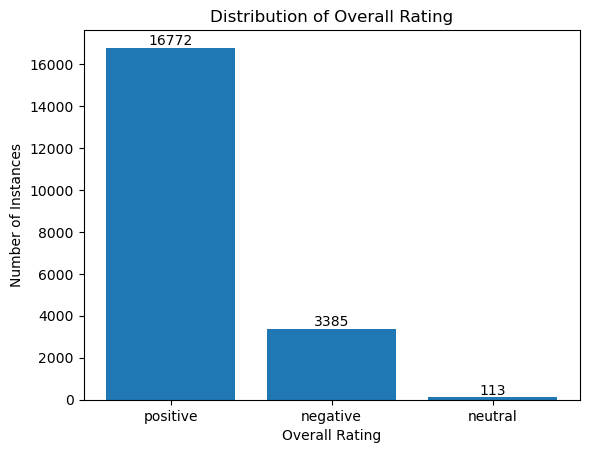

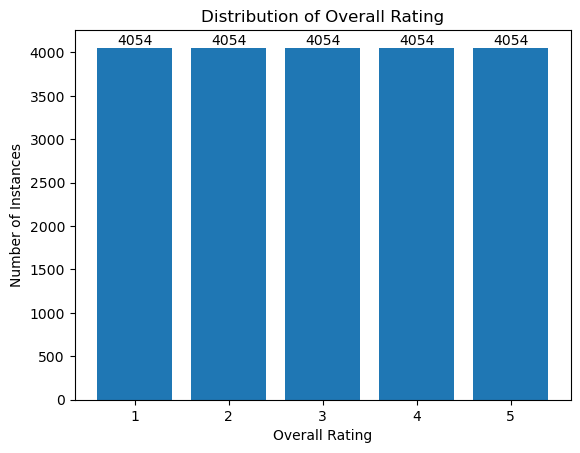

In [125]:
#From the distribution of the overall rating we can see that the VADER method is more likely to classify the reviews to"positive",there're only nealy 3400 samples classified as
#negative samples,which is nearly 600 lower than the sample with rating 1.That means VADER is more likely to regard the samples more positive.
#There are many reasons that may cause this phenomenon. In addition to the fact that the model itself may easily analyze the text as a positive meaning, 
#the wording of the comments may also cause this reason. For example, our previous analysis found that even with a score of 2, there are still words of 
#praise such as "great location", which may also affect the results of the model.
ratings = list(vader_results_df_word['VADER Sentiment'])
rating_counts = {}
for rating in ratings:
    if rating in rating_counts:
        rating_counts[rating] += 1
    else:
        rating_counts[rating] = 1

plt.bar(rating_counts.keys(), rating_counts.values())
plt.xlabel('Overall Rating')
plt.ylabel('Number of Instances')
plt.title('Distribution of Overall Rating')
for x, y in zip(rating_counts.keys(), rating_counts.values()):
    plt.text(x, y, str(y), ha='center', va='bottom')
plt.show()

ratings1 = [sample for sample in upsampled_df['overallscore']]
rating_counts = {}
for rating in ratings1:
    if rating in rating_counts:
        rating_counts[rating] += 1
    else:
        rating_counts[rating] = 1

plt.bar(rating_counts.keys(), rating_counts.values())
plt.xlabel('Overall Rating')
plt.ylabel('Number of Instances')
plt.title('Distribution of Overall Rating')

for x, y in zip(rating_counts.keys(), rating_counts.values()):
    plt.text(x, y, str(y), ha='center', va='bottom')

plt.show()


/tmp/ipykernel_2028830/2648161255.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  vader_results_df = pd.concat([vader_results_df, pd.DataFrame({'Text': [text], 'VADER Score': [vader_score]})], ignore_index=True)


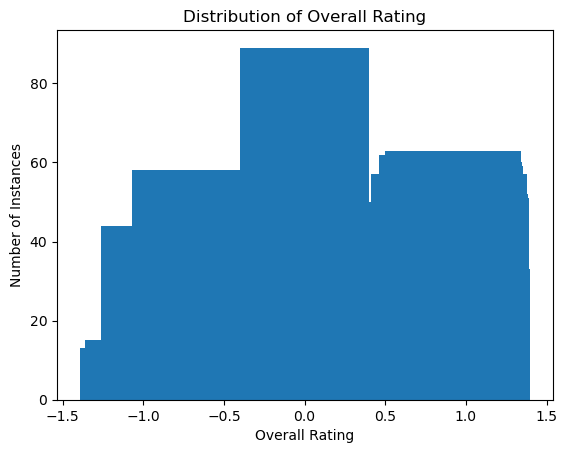

In [126]:
#Perhaps it is not appropriate to directly compare parts of speech and scores. We try to print the distribution of compound scores and compare them with scores.
#We found some changes in the analysis results. The overall compound score is high in the middle and low on both sides, that is, more concentrated in the middle.
#At the same time, there are slightly more positive words than negative words.
analyser = SentimentIntensityAnalyzer()
vader_results_df = pd.DataFrame(columns=['Text', 'VADER Score'])
for text in train_text_flat:
    score = analyser.polarity_scores(text)
    vader_score = score['compound']  
    
    vader_results_df = pd.concat([vader_results_df, pd.DataFrame({'Text': [text], 'VADER Score': [vader_score]})], ignore_index=True)
ratings = list(vader_results_df['VADER Score'])
rating_counts = {}
for rating in ratings:
    if rating in rating_counts:
        rating_counts[rating] += 1
    else:
        rating_counts[rating] = 1

plt.bar(rating_counts.keys(), rating_counts.values())
plt.xlabel('Overall Rating')
plt.ylabel('Number of Instances')
plt.title('Distribution of Overall Rating')
plt.show()


### 6. Combining VADER with the best classifier

In [ ]:
#There are some techniques to combine VADER with traditional ML method like using VADER to construct the label of the text and use
#it for training,which is mentioned by Chaithra,V.D[1].As we already have our label "rating",we won't use this method.Instead,since
#We've already seen the distribution of the compound score of VADER is different from that of oveallrating,it's better to just consider
#it as a feature and let the MNB model decide how to use the feature as part of the input,such method could be found in many
#cases,like in knowledge distilation the student model will get soft labels from the teacher model to get better performance,here we
#just consider it as a feature,which is also a kind of input information.

In [32]:
#We can see the SOTA combined with VADER also shows good peformance compared with the baseline(mean accuracy 0.8879 to baseline 0.8854).
new_df = pd.DataFrame()
new_df['combined'] = vader_results_df_word['VADER Sentiment'].astype(str) + ' ' + ste_df['newtext'].astype(str)
ste_text = new_df['combined']
vectorizer = CountVectorizer(ngram_range=(2, 2))
ste_ngrams = vectorizer.fit_transform(ste_text)
clf_1 = MultinomialNB()
kf = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(clf_1, ste_ngrams, y_train, cv=kf)
for i, score in enumerate(scores):
    print(f"Fold {i+1}: {score}")
print(f"Mean Accuracy: {scores.mean()}")

Fold 1: 0.8889985199802664
Fold 2: 0.8801184015786877
Fold 3: 0.8993586581154416
Fold 4: 0.8885051800690675
Fold 5: 0.8845584607794771
Fold 6: 0.8889985199802664
Fold 7: 0.882091761223483
Fold 8: 0.8830784410458806
Fold 9: 0.8934385791810557
Fold 10: 0.8894918598914652
Mean Accuracy: 0.8878638381845091


### 7. Trainig and testing the final method

In [92]:
#We use the 2-grams with stemmed words combing with MNB classifier again
#pre-process the train data and test data at the same time,upsample the train data to avoid imbalance data.
df_train = pd.DataFrame(train_data)  
df_test = pd.DataFrame(test_data)  
df_train['newtext'] = df_train['newtext'].apply(lambda x: [word for word in x if word not in stop_words])
df_test['newtext'] = df_test['newtext'].apply(lambda x: [word for word in x if word not in stop_words])
#resample the traindata 
max_samples = df_train['overallscore'].value_counts().max()
class_counts = df_train['overallscore'].value_counts()
class_diffs = max_samples - class_counts
upsampled_dfs = []
for class_label, diff in class_diffs.items():
    if diff==0:
        continue
    else:
        class_df = df_train[df_train['overallscore'] == class_label]
        upsampled_class = resample(class_df, replace=True, n_samples=diff)
        upsampled_dfs.append(upsampled_class)
upsampled_df_train = pd.concat([df_train] + upsampled_dfs)


In [93]:
#stem 2 datasets
stemmer = PorterStemmer()
ste_df_train=upsampled_df_train.copy()
ste_df_test=df_test.copy()
def stem_text(text):
    tokens = str(text).split()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    stemmed_text = ' '.join(stemmed_tokens)
    return stemmed_text

ste_df_train['newtext'] = ste_df_train['newtext'].apply(stem_text)
ste_df_test['newtext'] = ste_df_test['newtext'].apply(stem_text)

In [94]:
#use 2-Grams to transform the data
vectorizer=None
ste_train=ste_df_train['newtext']
ste_test=ste_df_test['newtext']
vectorizer = CountVectorizer(ngram_range=(2,2))
ste_ngrams_train = vectorizer.fit_transform(ste_train)
ste_ngrams_test = vectorizer.transform(ste_test)
y_train=ste_df_train["overallscore"]
y_test=ste_df_test["overallscore"]

In [95]:
#train
#What is surprising is that the model has serious overfitting(0.9986 to 0.5719), which has not occurred in the previous 10-fold verification.
#Next we will try to find out the reason.
clf_rf = MultinomialNB()
clf_rf.fit(ste_ngrams_train, y_train)
y_pred_train = clf_rf.predict(ste_ngrams_train)
print("Overall train accuracy: ", accuracy_score(y_train, y_pred_train))
y_pred_test = clf_rf.predict(ste_ngrams_test)
print("Overall test accuracy: ", accuracy_score(y_test, y_pred_test))

Overall train accuracy:  0.9985976789168278
Overall test accuracy:  0.5719


In [100]:
#We found that this problem can be solved if the test set is also upsampled. In the previous validation set test, we did upsampling in advance.
#This may be the reason why the two results are inconsistent.
#One possible reason is that the upsampling process changes the data distribution, causing the accuracy of the model trained on the validation set to be falsely high.
#Although upsampling the test set can solve this problem, this operation is not feasible in real problems. We only perform analysis.
df_train = pd.DataFrame(train_data)  
df_test = pd.DataFrame(test_data)  
df_train['newtext'] = df_train['newtext'].apply(lambda x: [word for word in x if word not in stop_words])
df_test['newtext'] = df_test['newtext'].apply(lambda x: [word for word in x if word not in stop_words])
#resample the traindata 
max_samples = df_train['overallscore'].value_counts().max()
class_counts = df_train['overallscore'].value_counts()
class_diffs = max_samples - class_counts
upsampled_dfs = []
for class_label, diff in class_diffs.items():
    if diff==0:
        continue
    else:
        class_df = df_train[df_train['overallscore'] == class_label]
        upsampled_class = resample(class_df, replace=True, n_samples=diff)
        upsampled_dfs.append(upsampled_class)
upsampled_df_train = pd.concat([df_train] + upsampled_dfs)
df_test = df_test[df_test['overallscore'] != 0]

#resample the testdata 
max_samples_train = df_test['overallscore'].value_counts().max()
class_counts_train = df_test['overallscore'].value_counts()
class_diffs_train = max_samples_train - class_counts_train
upsampled_dfs_test = []
for class_label, diff in class_diffs_train.items():
    if diff == 0:
        continue
    else:
        class_df = upsampled_df_train[upsampled_df_train['overallscore'] == class_label]
        upsampled_class = resample(class_df, replace=True, n_samples=diff)
        upsampled_dfs_test.append(upsampled_class)
df_test = pd.concat([df_test] + upsampled_dfs_test)
#stem 2 datasets
stemmer = PorterStemmer()
ste_df_train=upsampled_df_train.copy()
ste_df_test=df_test.copy()
def stem_text(text):
    tokens = str(text).split()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    stemmed_text = ' '.join(stemmed_tokens)
    return stemmed_text

ste_df_train['newtext'] = ste_df_train['newtext'].apply(stem_text)
ste_df_test['newtext'] = ste_df_test['newtext'].apply(stem_text)
#use 2-Grams to transform the data
vectorizer=None
ste_train=ste_df_train['newtext']
ste_test=ste_df_test['newtext']
vectorizer = CountVectorizer(ngram_range=(2,2))
ste_ngrams_train = vectorizer.fit_transform(ste_train)
ste_ngrams_test = vectorizer.transform(ste_test)
y_train=ste_df_train["overallscore"]
y_test=ste_df_test["overallscore"]

#train
clf_rf = MultinomialNB()
clf_rf.fit(ste_ngrams_train, y_train)
y_pred_train = clf_rf.predict(ste_ngrams_train)
print("Overall train accuracy: ", accuracy_score(y_train, y_pred_train))
y_pred_test = clf_rf.predict(ste_ngrams_test)
print("Overall test accuracy: ", accuracy_score(y_test, y_pred_test))

Overall train accuracy:  0.9985976789168278
Overall test accuracy:  0.791908359736778


In [99]:
#We tested the results of directly training the model without the upsampling step and found the following. 
#The results show that without upsampling, the problem of data set imbalance will occur, resulting in severe overfitting of the model.
#After figuring out the cause of the problem, we tried to use different upsampling methods to process only the training set and observe the results.
df_train = pd.DataFrame(train_data)  
df_test = pd.DataFrame(test_data)  
df_train['newtext'] = df_train['newtext'].apply(lambda x: [word for word in x if word not in stop_words])
df_test['newtext'] = df_test['newtext'].apply(lambda x: [word for word in x if word not in stop_words])

#stem 2 datasets
stemmer = PorterStemmer()
ste_df_train=df_train.copy()
ste_df_test=df_test.copy()

ste_df_train['newtext'] = ste_df_train['newtext'].apply(stem_text)
ste_df_test['newtext'] = ste_df_test['newtext'].apply(stem_text)
#use 2-Grams to transform the data
vectorizer=None
ste_train=ste_df_train['newtext']
ste_test=ste_df_test['newtext']
vectorizer = CountVectorizer(ngram_range=(2,2))
ste_ngrams_train = vectorizer.fit_transform(ste_train)
ste_ngrams_test = vectorizer.transform(ste_test)
y_train=ste_df_train["overallscore"]
y_test=ste_df_test["overallscore"]

#train
clf_rf = MultinomialNB()
clf_rf.fit(ste_ngrams_train, y_train)
y_pred_train = clf_rf.predict(ste_ngrams_train)
print("Overall train accuracy: ", accuracy_score(y_train, y_pred_train))
y_pred_test = clf_rf.predict(ste_ngrams_test)
print("Overall test accuracy: ", accuracy_score(y_test, y_pred_test))

Overall train accuracy:  0.9946
Overall test accuracy:  0.5308


In [106]:
#Previously we have used direct copying for upsampling,our test score is 0.5719.
#This time we'll use SMOTE as another kind of upsampling method.Our result is 0.5444.
from imblearn.over_sampling import SMOTE
df_train = pd.DataFrame(train_data)  
df_test = pd.DataFrame(test_data)  
df_train['newtext'] = df_train['newtext'].apply(lambda x: [word for word in x if word not in stop_words])
df_test['newtext'] = df_test['newtext'].apply(lambda x: [word for word in x if word not in stop_words])

#stem 2 datasets
stemmer = PorterStemmer()
ste_df_train=df_train.copy()
ste_df_test=df_test.copy()

ste_df_train['newtext'] = ste_df_train['newtext'].apply(stem_text)
ste_df_test['newtext'] = ste_df_test['newtext'].apply(stem_text)
#use 2-Grams to transform the data
vectorizer=None
ste_train=ste_df_train['newtext']
ste_test=ste_df_test['newtext']
vectorizer = CountVectorizer(ngram_range=(2,2))
ste_ngrams_train = vectorizer.fit_transform(ste_train)
ste_ngrams_test = vectorizer.transform(ste_test)
y_train=ste_df_train["overallscore"]
y_test=ste_df_test["overallscore"]

smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(ste_ngrams_train, y_train)

#train
clf_rf = MultinomialNB()
clf_rf.fit(X_train_resampled, y_train_resampled)
y_pred_train = clf_rf.predict(X_train_resampled)
print("Overall train accuracy: ", accuracy_score(y_train_resampled, y_pred_train))
y_pred_test = clf_rf.predict(ste_ngrams_test)
print("Overall test accuracy: ", accuracy_score(y_test, y_pred_test))

Overall train accuracy:  0.7188588007736944
Overall test accuracy:  0.5444


In [108]:
#We ended up using ADASYN for upsampling and the result was 0.5398
#The results show that we use the replication method to upsample the training set with the best performance, 
#and the accuracy can reach the results of 0.9986 for the training set and 0.5719 for the test set，which is our best model,yet still faces overfitting problem.
#Further actions could be considered to solve this problem including regularization method,etc.

from imblearn.over_sampling import ADASYN
df_train = pd.DataFrame(train_data)  
df_test = pd.DataFrame(test_data)  
df_train['newtext'] = df_train['newtext'].apply(lambda x: [word for word in x if word not in stop_words])
df_test['newtext'] = df_test['newtext'].apply(lambda x: [word for word in x if word not in stop_words])

#stem 2 datasets
stemmer = PorterStemmer()
ste_df_train=df_train.copy()
ste_df_test=df_test.copy()

ste_df_train['newtext'] = ste_df_train['newtext'].apply(stem_text)
ste_df_test['newtext'] = ste_df_test['newtext'].apply(stem_text)
#use 2-Grams to transform the data
vectorizer=None
ste_train=ste_df_train['newtext']
ste_test=ste_df_test['newtext']
vectorizer = CountVectorizer(ngram_range=(2,2))
ste_ngrams_train = vectorizer.fit_transform(ste_train)
ste_ngrams_test = vectorizer.transform(ste_test)
y_train=ste_df_train["overallscore"]
y_test=ste_df_test["overallscore"]

adasyn = ADASYN(sampling_strategy='minority', random_state=42)
X_train_resampled_adasyn, y_train_resampled_adasyn = adasyn.fit_resample(ste_ngrams_train, y_train)

#train
clf_rf = MultinomialNB()
clf_rf.fit(X_train_resampled_adasyn, y_train_resampled_adasyn)
y_pred_train = clf_rf.predict(X_train_resampled_adasyn)
print("Overall train accuracy: ", accuracy_score(y_train_resampled_adasyn, y_pred_train))
y_pred_test = clf_rf.predict(ste_ngrams_test)
print("Overall test accuracy: ", accuracy_score(y_test, y_pred_test))

Overall train accuracy:  0.9841292952824694
Overall test accuracy:  0.5398


### 8. Reviews aspect prediction

In addition to the overall rating, other ratings include the following sections: service, cleanliness, value, location, sleep quality, and rooms. In order to predict different aspects of evaluation using the same content, I think it is necessary to use different feature engineering. For example, for the "service" rating, more attention should be paid to sentences or paragraphs containing words such as "service", "staff", "reception", etc., and additional features should be extracted from these parts, such as sentiment scores or the frequency of occurrence of specific words. On this basis, word embeddings are used to generate feature vectors suitable for different prediction goals. At the same time, we can train an extractor in advance to initially extract the input text, and we can use the discriminator in GAN to help us identify features that focus on different aspects[2], so that the extractor can better generate representations that fit specific fields. We can also use reprgramming to pre-train a scoring system for a specific task (such as for cleaning, for location), and then use reprgramming to convert our features into features that only focus on evaluation and classification in a specific direction[3].

### 9. References

1.Chaithra, V. D. "Hybrid approach: naive bayes and sentiment VADER for analyzing sentiment of mobile unboxing video comments." International Journal of Electrical and Computer Engineering (IJECE) 9.5 (2019): 4452-4459.<br>
2.Zhang, Wei, and Xiang Li. "Federated transfer learning for intelligent fault diagnostics using deep adversarial networks with data privacy." IEEE/ASME Transactions on Mechatronics 27.1 (2021): 430-439.<br>
3.Zheng, Yang, et al. "Why adversarial reprogramming works, when it fails, and how to tell the difference." Information Sciences 632 (2023): 130-143.